In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import torch
from pathlib import Path
import numpy as np
import numba as nb
import pywt
import wfdb
from dataclasses import dataclass
from numpy.random import choice, shuffle
from matplotlib import pyplot as plt
from typing import Callable, List
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from CommonFunctions import *
%matplotlib inline

In [4]:
svdb_dir = Path('./svdb_dir')
svdb_files = [file.stem for file in svdb_dir.glob('*.dat')]
print(svdb_files)

['800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894']


In [5]:
time_window = 40
all_beats = []
all_annotations = []
for in_file in svdb_files:
    annotations = wfdb.rdann(str(os.path.join(svdb_dir, in_file)), 'atr')
    ann_symbols = annotations.symbol[5:-5]
    ann_locations = annotations.sample[5:-5]
    signal, fields = wfdb.rdsamp(str(os.path.join(svdb_dir, in_file)), channels=[0])
    signal = signal.flatten()
    for symbol, location in zip(ann_symbols, ann_locations):
        if symbol in ['N', 'S', 'V']:
            all_beats.append(signal[location - time_window: location + time_window])
            all_annotations.append(symbol)
all_beats = np.vstack(all_beats)
all_annotations = np.array(all_annotations)
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

(183707, 80) (183707,)
no of N beats: 161653
no of S beats: 12146
no of V beats: 9908


In [6]:
def randomly_pick_indexes(labels: np.array, quantity: int, proportions: dict[str, float]):
    group_labels = list(proportions.keys())
    group_proportions = [round(quantity * p) for p in proportions.values()]
    picks = []
    for label, proportion in zip(group_labels, group_proportions):
        group = np.where(labels == label)[0]
        picks.append(choice(group, size=proportion, replace=False))
    picks = np.hstack(picks)
    shuffle(picks)
    return picks

def plot_random_beats(beats, beat_annotations, size, proportions, title=None, file=None):
    colors = {'N': 'lime', 'S': 'blue', 'V': 'red'}
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(*size, layout='constrained', figsize=(12, 12))
        fontsize = figure.axes[0].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        fontsize = fontsize.width * 0.15 * figure.dpi
        random_ann_labels = randomly_pick_indexes(beat_annotations, size[0] * size[1], proportions)
        for ax, random_index in zip(figure.axes, random_ann_labels):
            ax.plot(beats[random_index], color=colors[beat_annotations[random_index]])
            ax.text(x=0.02, y=0.98, s=f'{beat_annotations[random_index]}',
                    transform=ax.transAxes, fontweight='bold', fontsize=fontsize)
            ax.axis(False)
            enhance_plot(figure, ax, glow=True, alpha_gradient=0.8, dpi=150)
        figure.suptitle(title, )
    if file is None:
        figure.savefig(f'images/random_beat_images{"x".join([str(coord) for coord in size])}.png')
    else:
        figure.savefig(f'images/{file}.png')

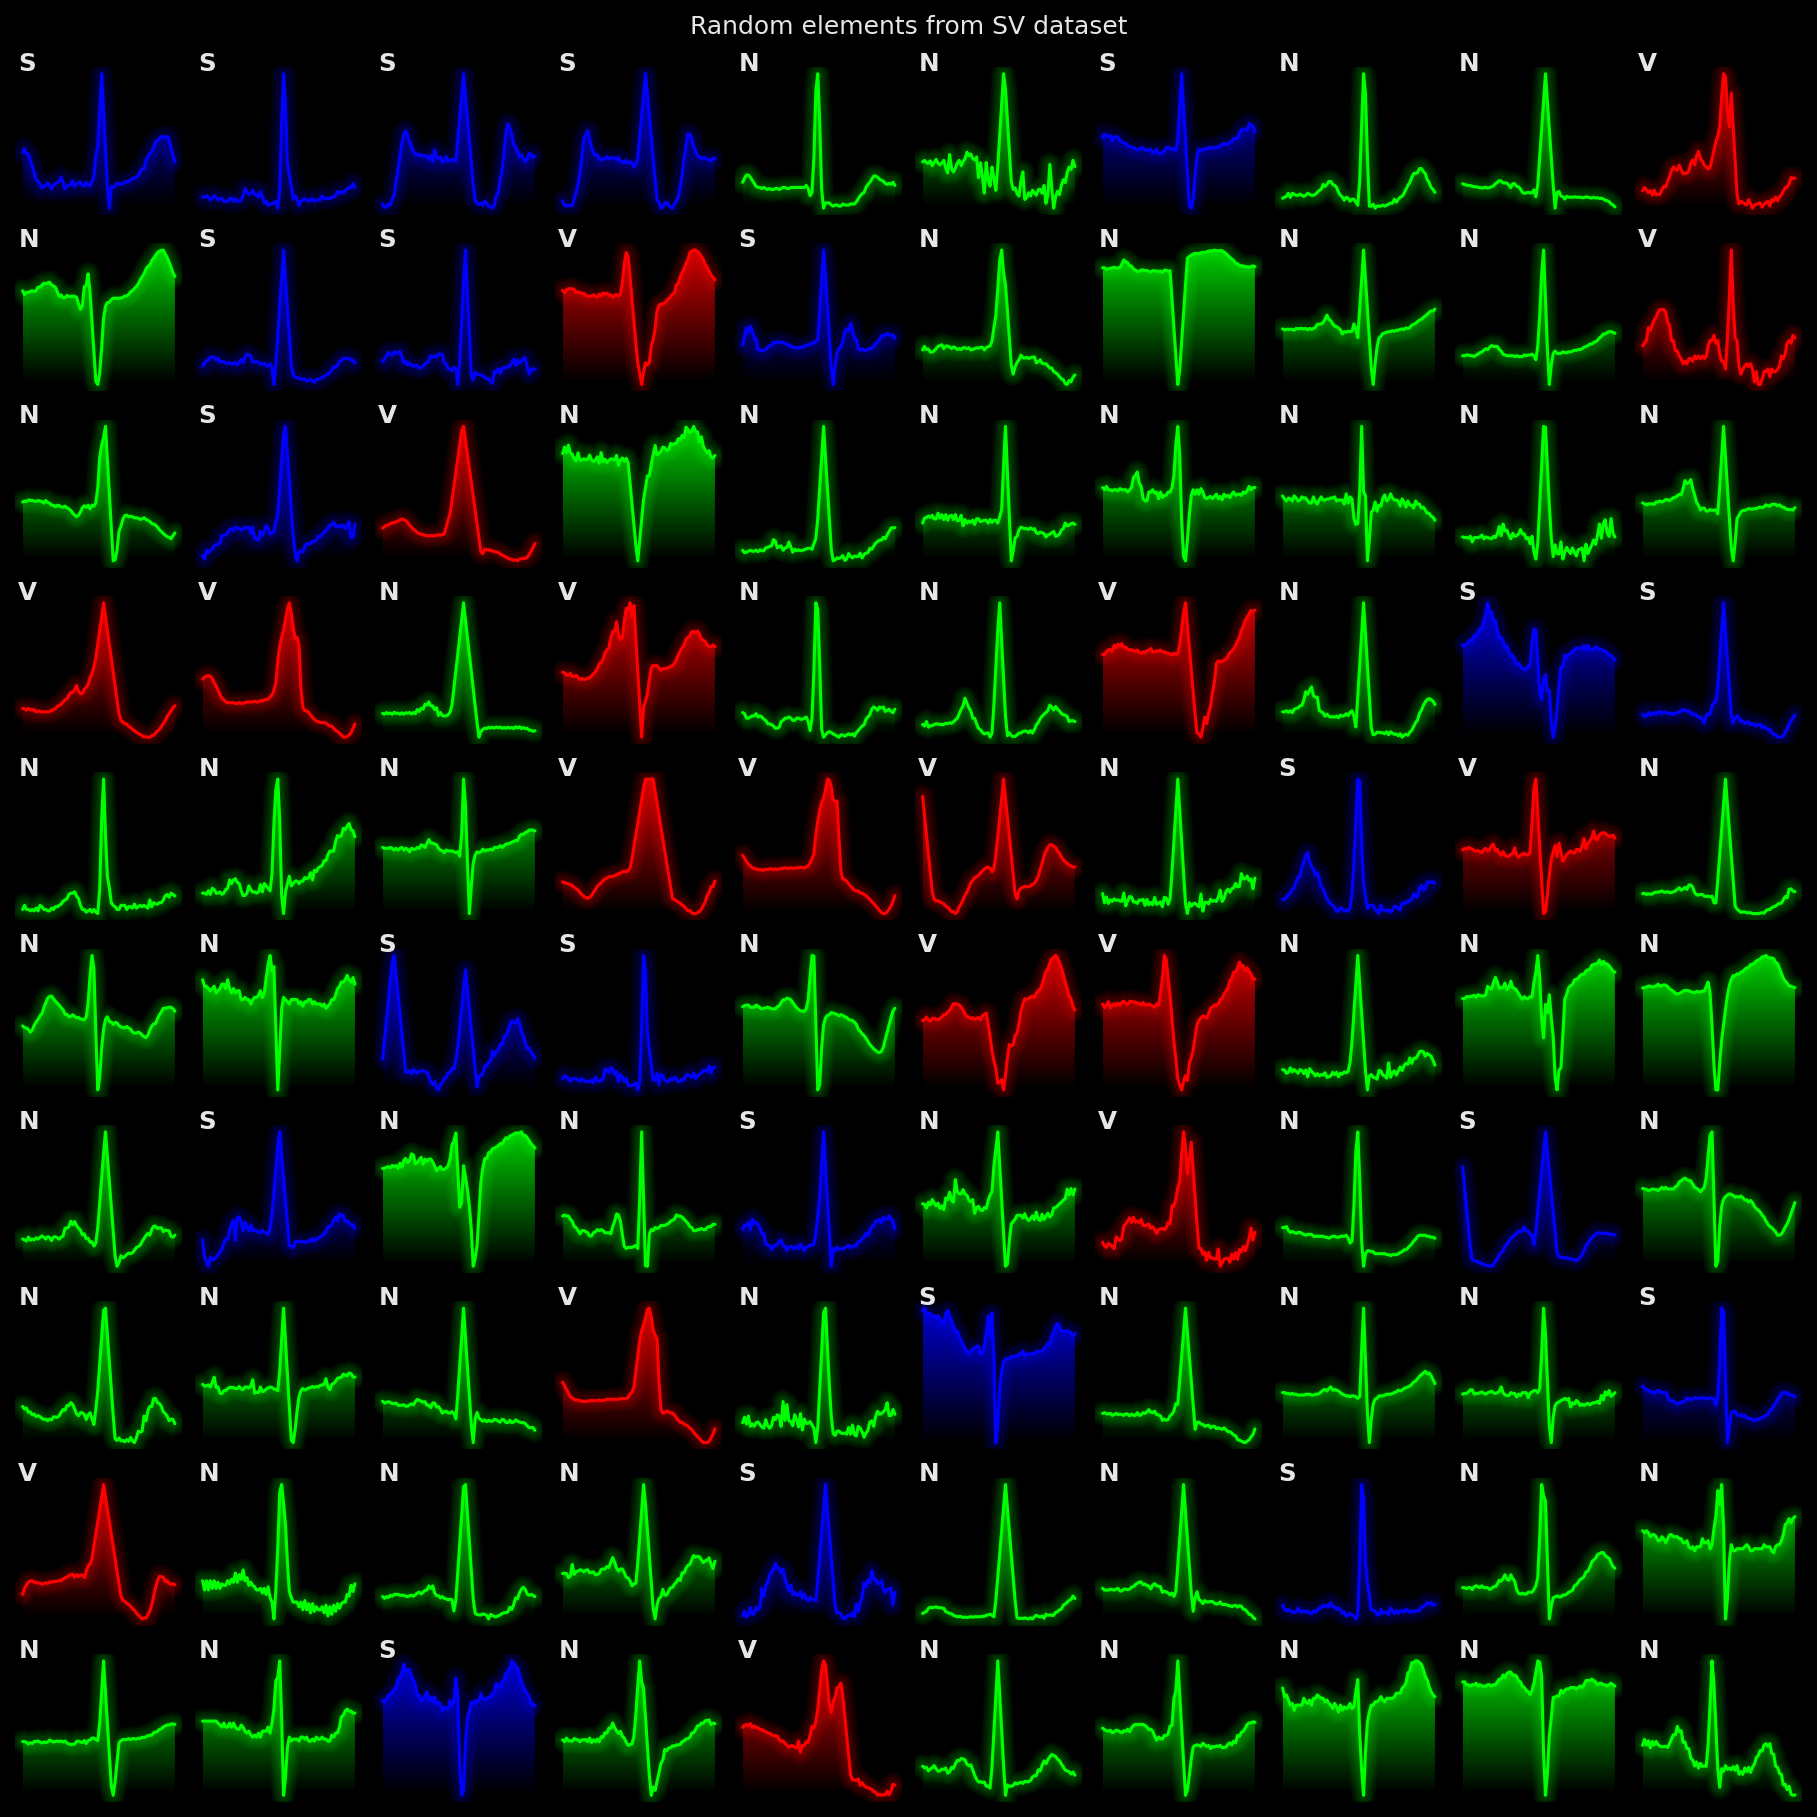

In [7]:
fig_title = 'Random elements from SV dataset'
props = {'N': 0.6, 'S': 0.22, 'V': 0.18}
plot_random_beats(all_beats, all_annotations, (10, 10), props, title=fig_title)

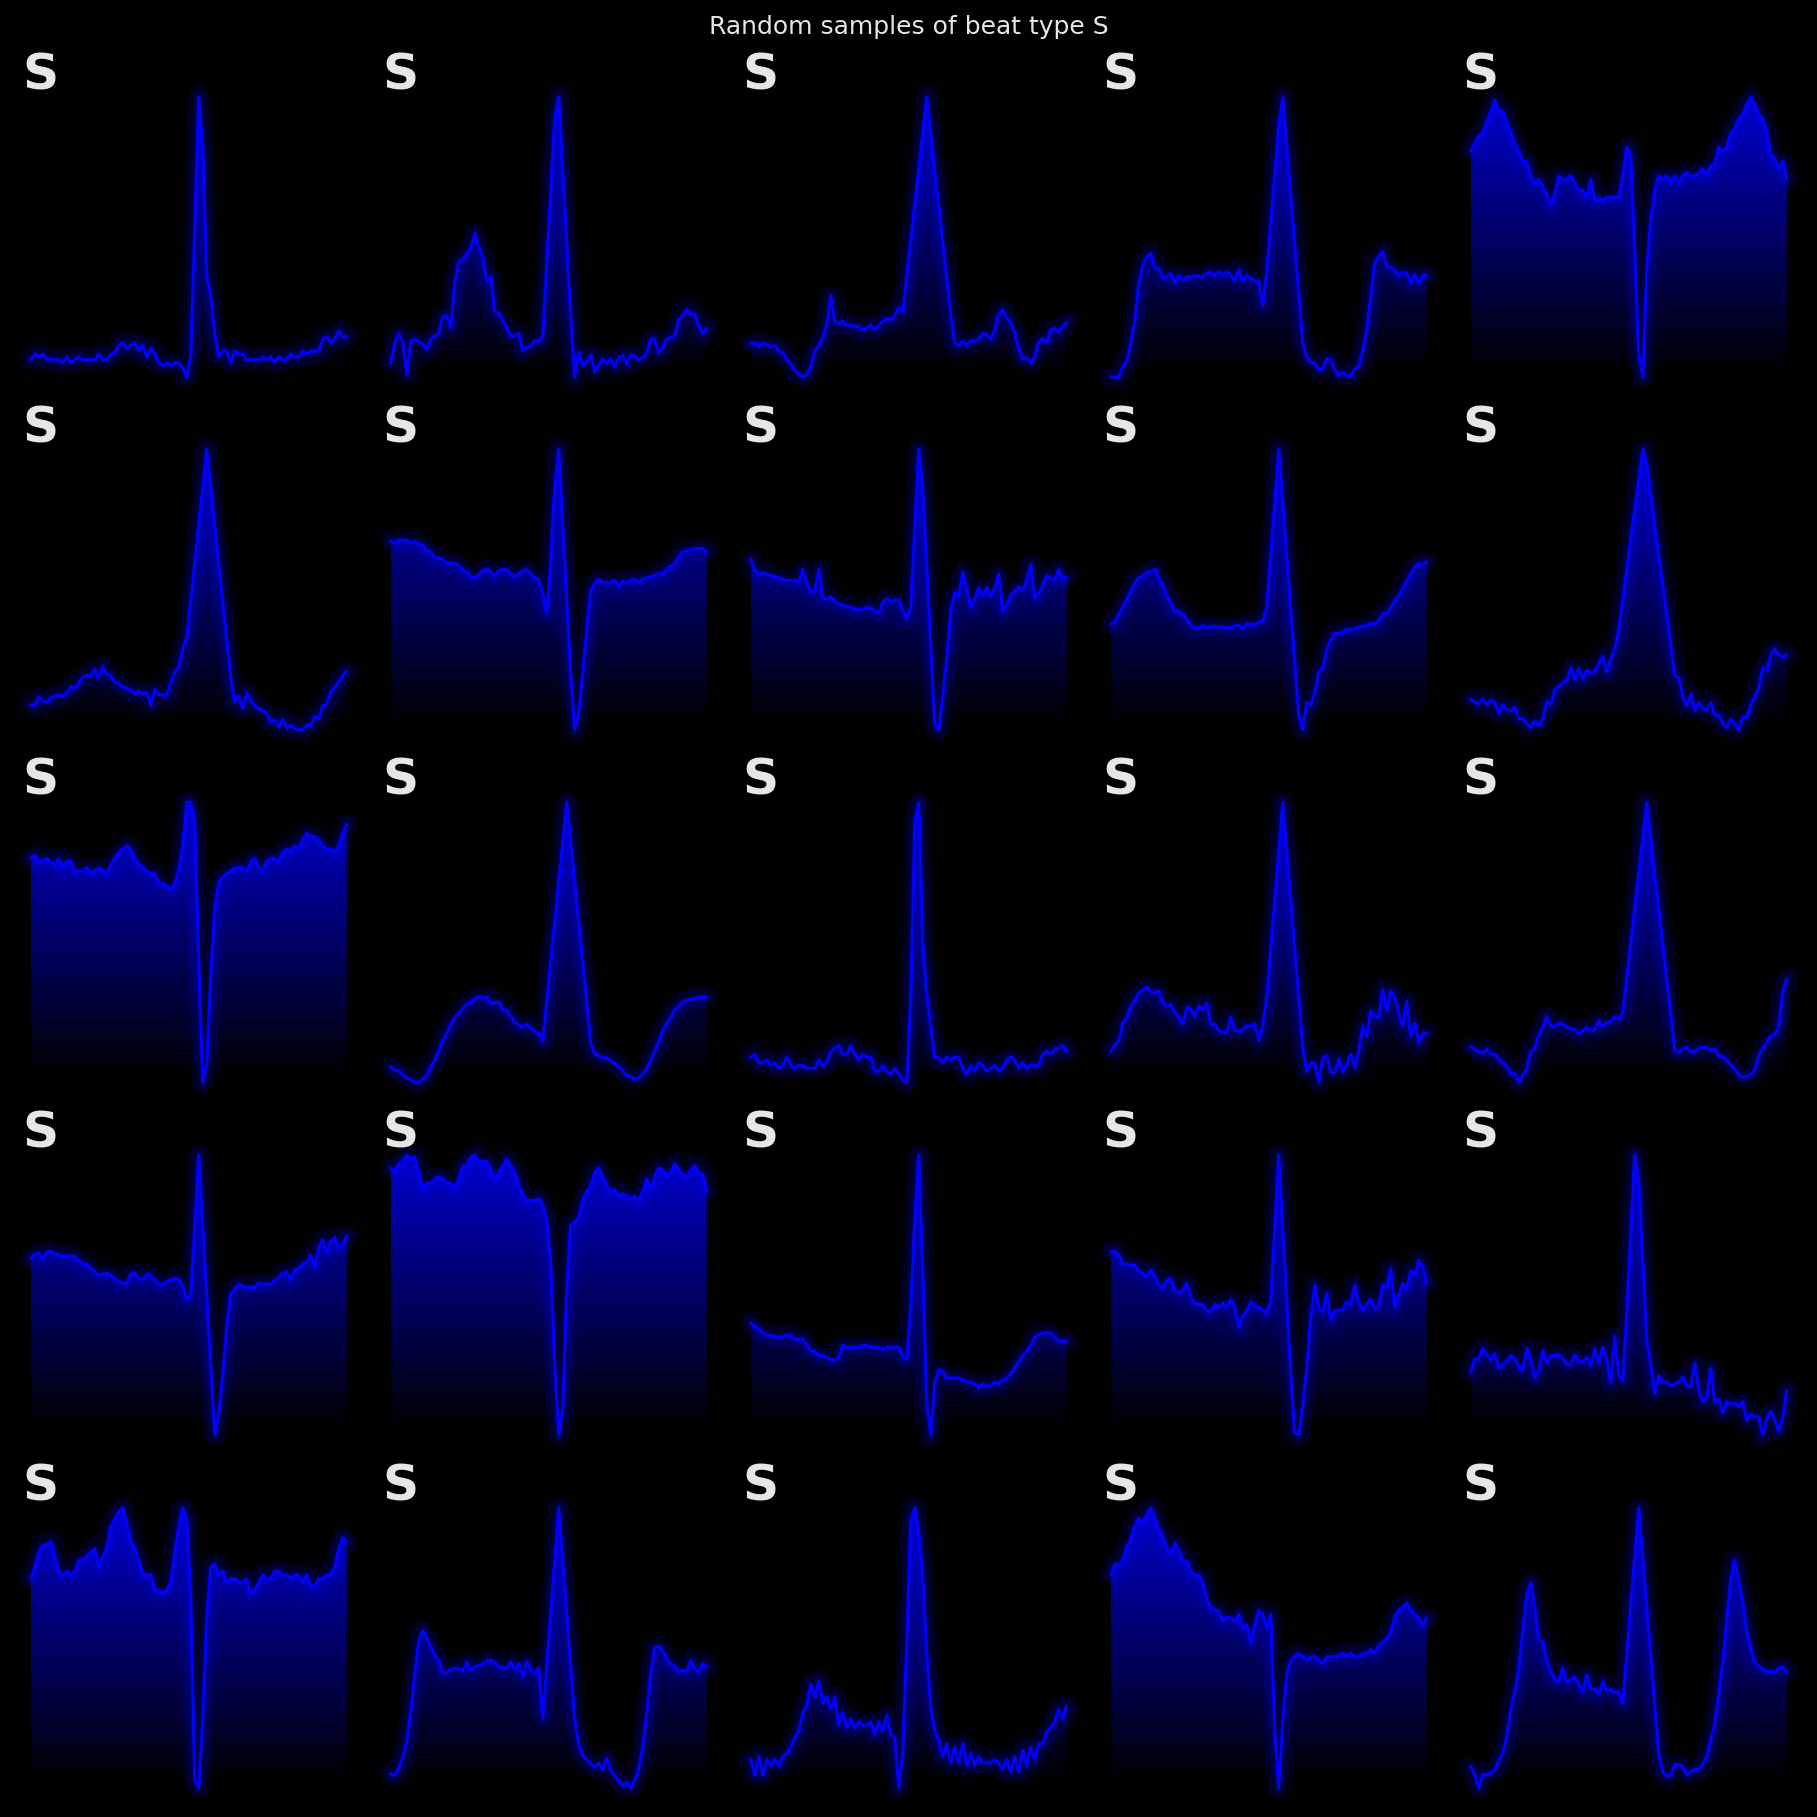

In [8]:
fig_title = 'Random samples of beat type S'
props = {'N': 0., 'S': 1., 'V': 0.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeS')

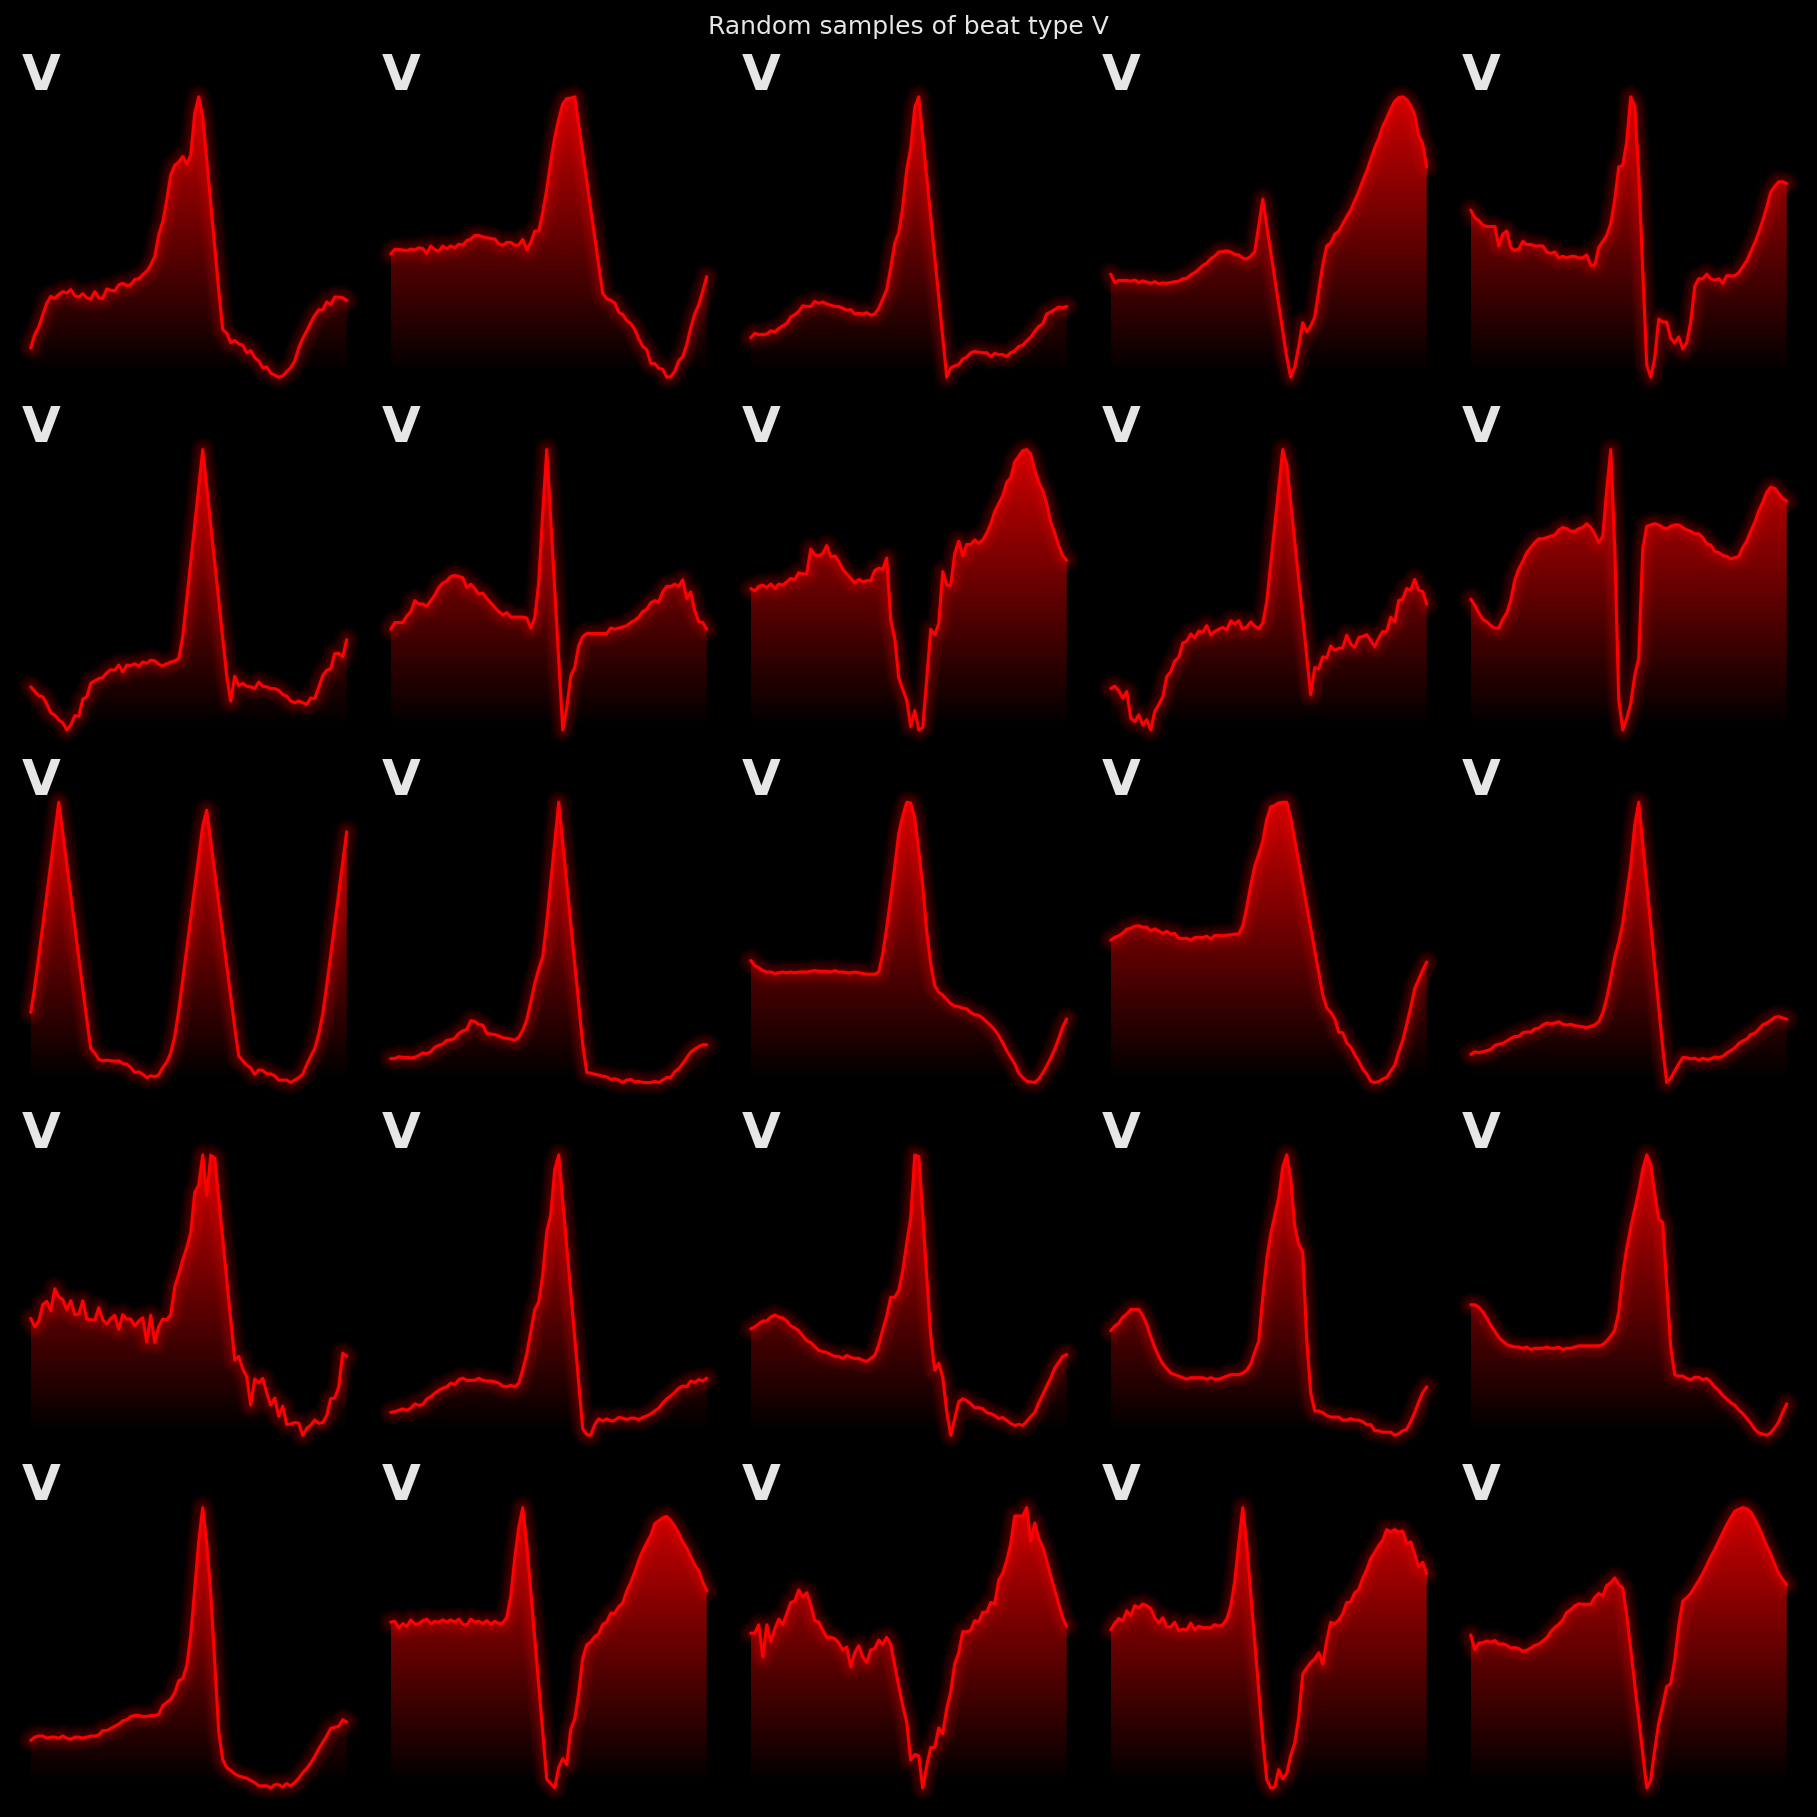

In [9]:
fig_title = 'Random samples of beat type V'
props = {'N': 0., 'S': 0., 'V': 1.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeV')

# Creating Custom Data-Loader object

In [10]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.7
    weight_decay: float = 0.005
    epochs: int = 75
    device: torch.device = torch.device('cpu')
    dropout: float = 0.3
    batch_norm: bool = True
params = LearningParameters()

In [11]:
class ECGDataset(Dataset):
    def __init__(self, waveforms, labels, transform=None):
        self.waveforms = waveforms
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx]
        if self.transform:
            waveform = self.transform(waveform)
        
        return (torch.tensor(waveform, dtype=torch.float32), 
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [12]:
class ECGModel(nn.Module):
    def __init__(self, waveform_len, activation=nn.ReLU()):
        super(ECGModel, self).__init__()
        
        self.waveform_net = nn.Sequential(
            nn.Linear(waveform_len, 128),
            activation,
            nn.Linear(128, 64),
            activation,
        )
        self.combined_net = nn.Sequential(
            nn.Linear(64, 32),
            activation,
            nn.Linear(32, 3),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, waveform):
        return self.combined_net(self.waveform_net(waveform))

In [13]:
def calculate_accuracy(y_pred, y_true):
    acc_t = torch.count_nonzero(y_pred == y_true, dim=1)

In [16]:
split = int(0.7 * len(all_annotations))
ecg_dataset_train = ECGDataset(all_beats[:split], all_annotations[:split])
ecg_dataset_test = ECGDataset(all_beats[split:], all_annotations[split:])
train_dataloader = DataLoader(ecg_dataset_train, batch_size=params.batch_size, shuffle=True)
test_dataloader = DataLoader(ecg_dataset_test, batch_size=params.batch_size, shuffle=False)
len(train_dataloader), len(test_dataloader), len(all_beats[0])

(1005, 431, 80)

In [17]:
model1 = ECGModel(len(all_beats[0]))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model1.parameters(), lr=params.learning_rate, momentum=params.momentum)
model1

ECGModel(
  (waveform_net): Sequential(
    (0): Linear(in_features=80, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (combined_net): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
    (3): LogSoftmax(dim=1)
  )
)

In [ ]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []